# Semi-Supervised Learning with Spectral Graph Convolutions
> [**How to do Deep Learning on Graphs with Graph Convolutional Networks** Part 2: Semi-Supervised Learning with Spectral Graph Convolutions](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0)

## Spectral Graph Convolutions

### The Sum Rule

- The $i$th row in the aggregate (feature representation of the $i$th node) is computed:
$$
\begin{equation}
\begin{aligned}
aggregate(A, X)_i&=A_iX \\
&=\sum_{j=1}^{N}A_{ij}X_{j}
\end{aligned}
\end{equation}
$$
- We can compute the aggregate feature representation of the $i$th node as a **vector-matrix product** (e.g.,simple weighted sum)
- Corresponds to summing up the feature representations of the neighbors of the $i$th node

### The Mean Rule

- The $i$th row in the aggregate is computed (only consider on the raw adjacency matrix $A$ for simplicity):
$$
\begin{equation}
\begin{aligned}
aggregate(A, X)_i&=D^{-1}A_iX \\
&=\sum_{k=1}^{N}D_{ik}^{-1}\sum_{j=1}^{N}A_{ij}X_{j} \\
&=\sum_{j=1}^{N}D_{ii}^{-1}A_{ij}X_{j} \\
&=\sum_{j=1}^{N}\frac{A_{ij}}{D_{ii}}X_{j} \\
\end{aligned}
\end{equation}
$$
- The inverse degree matrix $D^{-1}$ is a diagonal matrix where the values along the diagonal are inverse node degrees s.t. the value at position $(i, i)$ is the inverse degree of the $i$th node
- The weights in the weighted sum are now guaranteed to sum to 1 by with the degree of the $i$th node
- Corresponds to a mean over the feature representations of the neighbors of the $i$th node

*Whereas the sum rule depends solely on the neighborhood defined by the adjacency matrix $A$, the mean rule also depends on node degrees.*

### The Spectral Rule

$$
\begin{equation}
\begin{aligned}
aggregate(A, X)_i&=D^{-0.5}A_iD^{-0.5}X \\
&=\sum_{k=1}^{N}D_{ik}^{-0.5}\sum_{j=1}^{N}A_{ij}\sum_{l=1}^{N}D_{jl}^{-0.5}X_{j} \\
&=\sum_{j=1}^{N}D_{ii}^{-0.5}A_{ij}D_{jj}^{-0.5}X_{j} \\
&=\sum_{j=1}^{N}\frac{A_{ij}}{D_{ii}^{0.5}D_{jj}^{0.5}}X_{j} \\
\end{aligned}
\end{equation}
$$
- Raise the degree matrix to the power of -0.5 and multiply it on each side of $A$
- Not only take into consideration the degree of the $i$th node, but also the degree of the $j$th node
- The spectral rule weighs neighbor in the weighted sum higher if they have a low-degree and lower if they have a high-degree (This may be useful when low-degree neighbors provide more useful information than high-degree neighbors)

## Semi-Supervised Classification with GCNs
- We have implicitly assumed that the entire graph is available, i.e., that we are in a transductive setting. In other words, we know all the nodes, but not all the node labels.
- In all the rules, we aggregate over node neighborhoods, and thus nodes that share neighbors tend to have similar feature representations. This property is very useful if the graph exhibits homophily, i.e., that connected nodes tend to be similar (e.g. have the same label).
- We can take this a step further by training the GCN on the labeled nodes, effectively propagating the node label information to unlabelled nodes by updating weight matrices that are shared across all nodes. This can be done as follows:
    1. Perform forward propagation through the GCN.
    2. Apply the sigmoid function row-wise on the last layer in the GCN.
    3. Compute the cross entropy loss on known node labels.
    4. Backpropagate the loss and update the weight matrices W in each layer.

## Load Zachary's Karate Club Network

In [78]:
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
import numpy as np
from keras.utils import to_categorical

# from github.com/tkipf/keras-gcn
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

def loadZacharyKarateClubNetwork():
    network = read_edgelist('karate.edgelist', nodetype=int)
    attributes = read_csv('karate.attributes.csv', index_col=['node'])
    labels = encode_onehot(np.array(attributes['community']))
    for attr in attributes.columns.values:
        set_node_attributes(network, 
                            values=Series(attributes[attr], index=attributes.index).to_dict(),
                            name=attr)
    
    idx_train = [node for node, data in network.nodes(data=True) if data['role'] in {'Administrator', 'Instructor'}]
    idx_test = [node for node, data in network.nodes(data=True) if data['role'] == 'Member']
    y_train = np.zeros(labels.shape, dtype=np.int32)
    y_test = np.zeros(labels.shape, dtype=np.int32)
    y_train[idx_train] = labels[idx_train]
    y_test[idx_test] = labels[idx_test]
    mask = np.zeros(labels.shape[0])
    mask[idx_train] = 1
    train_mask =  np.array(mask, dtype=np.bool)
    return network, labels, y_train, y_test, idx_train, idx_test, train_mask

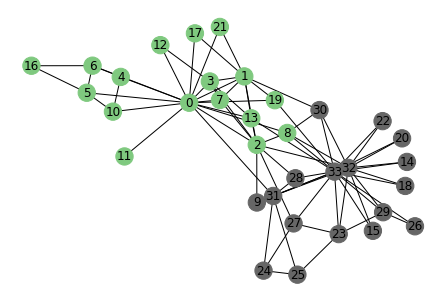

In [79]:
from networkx import spring_layout, draw
import matplotlib.pyplot as plt

zkc_net, labels, y_train, y_test, idx_train, idx_test, sample_mask = loadZacharyKarateClubNetwork()
pos = spring_layout(zkc_net)
node_map = {
    'Administrator' : 0,
    'Instructor' : 0.2
}
colors = [node_map.get(zkc_net.nodes[node]['community']) for node in zkc_net.nodes]
draw(zkc_net, cmap = plt.get_cmap('Accent'), node_color=colors, with_labels=True, pos=pos)

In [80]:
from networkx import to_numpy_matrix

def normalize_adj(A):
    I = np.eye(zkc_net.number_of_nodes())
    A_s = A + I
    D_hat = np.diag(np.array(np.power(np.sum(A_s, axis=0), -0.5))[0])
    return D_hat.dot(A_s).dot(D_hat)

order = sorted(list(zkc_net.nodes()))
A = to_numpy_matrix(zkc_net, nodelist=order)
A_norm = normalize_adj(A)

### Representation 1

Use the sparse 34 × 34 identity matrix $I$, as the feature matrix $X$, i.e., a one-hot encoding of each node in the graph
- it can be used in any graphs
- but results in an input parameter for each node in the network which requires a substantial amount of memory and computional power for training on large networks and may result in overfitting

In [81]:
def evaluate_preds(preds, labels, indices):
    return np.mean(np.equal(np.argmax(labels[indices], 1), np.argmax(preds[indices], 1)))

In [92]:
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.optimizers import Adam
from GCN import GraphConv

X_1 = np.eye(zkc_net.number_of_nodes())

featureInput = Input(shape=(X_1.shape[1],))
adjInput = Input(shape=(None, None), batch_shape=(None, None))
H1 = GraphConv(4, activation='tanh', name='graph_conv_1')([featureInput, adjInput])
H2 = GraphConv(2, activation='tanh', name='graph_conv_2')([H1, adjInput])
H3 = Dense(2, activation='sigmoid')(H2)

model1 = Model(inputs=[featureInput, adjInput], outputs=H3)
model1.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy')
model1.summary()

history = model1.fit([X_1, A_norm], y_train, sample_weight=sample_mask,
          batch_size=X_1.shape[0], epochs=5000, shuffle=False, verbose=0)

preds = model1.predict([X_1, A_norm], batch_size=X_1.shape[0])
print("train_acc= {:.4f}".format(evaluate_preds(preds, labels, idx_train)), 
      "test_acc= {:.4f}".format(evaluate_preds(preds, labels, idx_test)))


Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 4)            140         input_71[0][0]                   
                                                                 input_72[0][0]                   
__________________________________________________________________________________________________
graph_conv_2 (GraphConv)        (None, 2)            10          graph_conv_1[0][0]        

### Representation 2

Improve representation 1 by adding two features that are not specific to any node or area of the network, but measures the connectedness to the administrator and instructor.
Compute the shortest path distance from each node in the network to both the administrator and instructor and concatenate these two features to the previous representation
- the graph convolutional layers always have a local perspective and has a limited capacity to capture global information about the location of each node in the graph

In [77]:
from networkx import shortest_path_length

X_2 = np.zeros((zkc_net.number_of_nodes(), 2))
node_distance_instructor = shortest_path_length(zkc_net, target=33)
node_distance_administrator = shortest_path_length(zkc_net, target=0)

for node in zkc_net.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]
    
X_2 = np.concatenate((X_1, X_2), axis=1)

featureInput = Input(shape=(X_2.shape[1],))
adjInput = Input(shape=(None, None), batch_shape=(None, None))
H1 = GraphConv(4, activation='tanh')([featureInput, adjInput])
H2 = GraphConv(2, activation='sigmoid')([H1, adjInput])

model2 = Model(inputs=[featureInput, adjInput], outputs=H2)
model2.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit([X_2, A_norm], y_train, sample_weight=sample_mask,
          batch_size=X_2.shape[0], epochs=250, shuffle=False, verbose=0)

preds = model2.predict([X_2, A_norm], batch_size=X_2.shape[0])
print("train_acc= {:.4f}".format(evaluate_preds(preds, labels, idx_train)),
      "test_acc= {:.4f}".format(evaluate_preds(preds, labels, idx_test)))

train_acc= 1.0000 test_acc= 0.9688
